In [ ]:
!apt install git-lfs

In [ ]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())
dtype = torch.float
device = torch.device("mps")

In [34]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)

Loading cached shuffled indices for dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-0b126a62dc97ecba.arrow



'>> Title: Worked in front position, not rear'
'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.'

'>> Title: meh'
'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue'

'>> Title: Can't beat these for the money'
'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. 

In [38]:
english_df=english_df[['review_body','review_title']]
english_df=english_df.dropna()

In [39]:
len(english_df.index)

200000

In [40]:
# Zähle die Wortanzahl auf jede Zeile in der Spalte 'review_title' und 'review_body' an
english_df['review_title_counts'] = english_df['review_title'].apply(lambda x: len(str(x).split()))
english_df['review_body_counts'] = english_df['review_body'].apply(lambda x: len(str(x).split()))
english_df['kompression']=round(english_df['review_title_counts']/english_df['review_body_counts']*100,2)

In [42]:
english_df.loc[169285][['review_body_counts','review_body']]

review_body_counts                                                  247
review_body           Bought this for handling miscellaneous aircraf...
Name: 169285, dtype: object

In [43]:
# der review title = die zusammenfassung
english_df.head()

,review_body,review_title,review_title_counts,review_body_counts,kompression
0,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,22,112,19.64
1,the cabinet dot were all detached from backing...,Not use able,3,10,30.00
2,I received my first order of this product and ...,The product is junk.,4,40,10.00
3,This product is a piece of shit. Do not buy. D...,Fucking waste of money,4,29,13.79
4,went through 3 in one day doesn't fit correct ...,bubble,1,16,6.25


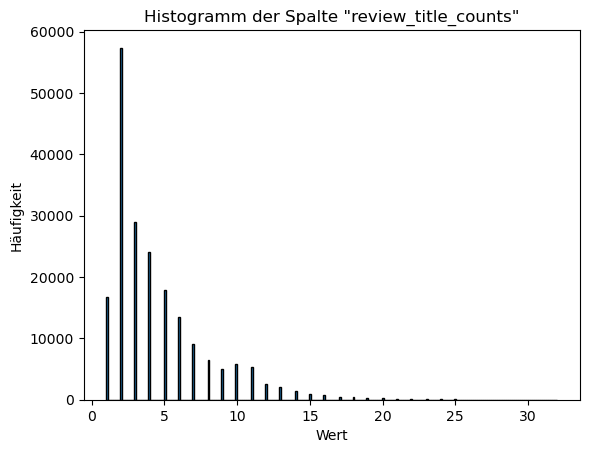

In [45]:
plot_histogram(english_df, 'review_title_counts')

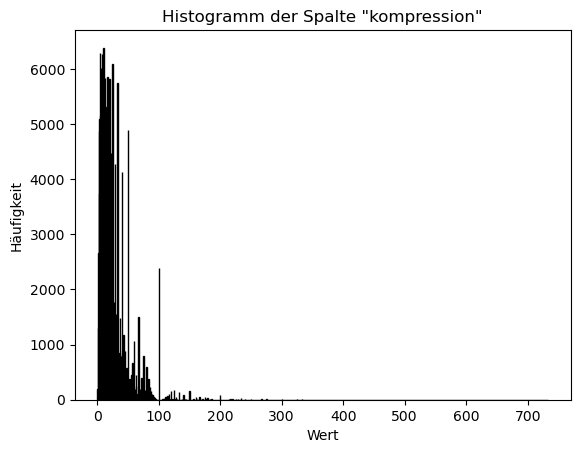

In [47]:
 plot_histogram(english_df, 'kompression')

# Model train


In [48]:
from transformers import AutoTokenizer

model_checkpoint = "t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/Users/niclascramer/opt/miniconda3/envs/torch/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [49]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")


english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

Found cached dataset amazon_reviews_multi (/Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset amazon_reviews_multi (/Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: product_category, dtype: int64

In [50]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

In [51]:
english_dataset.reset_format()
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

Loading cached processed dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-1f8a8639b644779a.arrow
Loading cached processed dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e24d64f51478b699.arrow
Loading cached processed dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-be78948bbd5c9f80.arrow


Flattening the indices:   0%|          | 0/11 [00:00<?, ?ba/s]


Row Number: 789
'>> Title: I'm dissapointed.'
'>> Review: I guess I had higher expectations for this book from the reviews. I really thought I'd at least like it. The plot idea was great. I loved Ash but, it just didnt go anywhere. Most of the book was about their radio show and talking to callers. I wanted the author to dig deeper so we could really get to know the characters. All we know about Grace is that she is attractive looking, Latino and is kind of a brat. I'm dissapointed.'

Row Number: 4776
'>> Title: Good art, good price, poor design'
'>> Review: I had gotten the DC Vintage calendar the past two years, but it was on backorder forever this year and I saw they had shrunk the dimensions for no good reason. This one has good art choices but the design has the fold going through the picture, so it's less aesthetically pleasing, especially if you want to keep a picture to hang. For the price, a good calendar'

Row Number: 10320
'>> Title: Helpful'
'>> Review: Nearly all the tips

In [52]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [53]:
tokenized_datasets = english_books.map(preprocess_function, batched=True)

Loading cached processed dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-d9be55edb2f6380e.arrow
Loading cached processed dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8a909fb6470b3bc1.arrow
Loading cached processed dataset at /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-ab7f469c8f0781ae.arrow


In [54]:
import evaluate

rouge_score = evaluate.load("rouge")

In [55]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [56]:
import evaluate

rouge_score = evaluate.load("rouge")

In [57]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [58]:
scores["rouge1"].mean()

0.923076923076923

In [59]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niclascramer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(english_books["train"][1]["review_body"]))

I ordered this book on February 11.
It never arrived.


In [61]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [62]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niclascramer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
import pandas as pd

score = evaluate_baseline(english_books["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 10.37, 'rouge2': 5.26, 'rougeL': 9.77, 'rougeLsum': 10.03}

In [64]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [65]:
from huggingface_hub import notebook_login

notebook_login()

In [66]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-test_2",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [67]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mean() * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [68]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [69]:
tokenized_datasets  = tokenized_datasets.remove_columns(
    english_books["train"].column_names
)

In [61]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[ 3059,  4779,  6833,    65,   349,    38,     8,   167, 19930,   120,
           147, 25444,  4346,     5,  1203,    27,  6220,     8,  2291,    19,
             3,     9, 24556,     5, 20510,  9412,     5,     1],
        [   27,  5563,    48,   484,    30,  2083,  7806,    94,   470,  4363,
             5,     1,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]]), 'labels': tensor([[  499,  8581,    48,   484,  3290,    22,    17,   414,     1],
        [25629,    12,  1299,   484,     1,  -100,  -100,  -100,  -100]]), 'decoder_input_ids': tensor([[    0,   499,  8581,    48,   484,  3290,    22,    17,   414],
        [    0, 25629,    12,  1299,   484,     1,     0, 

In [62]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [63]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/Users/niclascramer/opt/miniconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/NICFRU/t5-large-finetuned-amazon-test_2 into local empty directory.


In [64]:
from transformers import Trainer
trainer.train()

/Users/niclascramer/opt/miniconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10505
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10512
  Number of trainable parameters = 737668096


  0%|          | 0/10512 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

Fine-tuning T5 with Accelerate

In [ ]:
tokenized_datasets.set_format("torch")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "t5-finetuned-amazon-test"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value.mean() * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

Testen der Modelle

In [90]:
def create_summary(model, tokenizer, text, max_length=512, min_length=30, length_penalty=5.0, repetition_penalty=5.0, num_beams=3):
    '''Description: Call HuggingFace T5 model to generate abstractive summary 
       Input: a pre-trained T5 model, a T5 tokenizer, an original text to summarize and a set of tunable hyperprams 
       Output: an abstractive summary text generated by T5 
       
       Note: You could try different values for tuning hyperprams to control the summary length.
       Specifically you could use the `length_penalty` argument. 
       Set to values < 1.0 in order to encourage the model to generate shorter sequences, 
       to a value > 1.0 in order to encourage the model to produce longer sequences.
       Be default generate will use arguments from config or config.task_specific_params 
       but you could also directly pass these args to generate to override them
    '''
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=max_length, truncation=True)
    outputs = model.generate(
        inputs, 
        max_length=max_length, 
        min_length=min_length, 
        length_penalty=length_penalty,
        repetition_penalty=repetition_penalty,
        num_beams=num_beams, 
        early_stopping=True)
    print(tokenizer.decode(outputs[0]))

In [ ]:
create_summary(model, tokenizer, text, max_length=512, min_length=30, length_penalty=5.0, repetition_penalty=5.0, num_beams=3)

In [92]:
from transformers import pipeline

hub_model_id = "NICFRU/t5-large-finetuned-amazon-test_2"
text='It is not mush of guide.It kinda sucks I wish I wanted for the official one'
model = pipeline("summarization", model=hub_model_id)
create_summary(model, tokenizer, text, max_length=10, min_length=5, length_penalty=5.0, repetition_penalty=5.0, num_beams=3)


loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/config.json
Model config T5Config {
  "_name_or_path": "NICFRU/t5-large-finetuned-amazon-test_2",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 4096,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
    

AttributeError: 'SummarizationPipeline' object has no attribute 'generate'

In [81]:
from transformers import pipeline

hub_model_id = "NICFRU/t5-large-finetuned-amazon-test_2"
summarizer = pipeline("summarization", model=hub_model_id)

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/config.json
Model config T5Config {
  "_name_or_path": "NICFRU/t5-large-finetuned-amazon-test_2",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 4096,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
    

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/pytorch_model.bin
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at NICFRU/t5-large-finetuned-amazon-test_2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

loading file spiece.model from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/spiece.model
loading file tokenizer.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--NICFRU--t5-large-finetuned-amazon-test_2/snapshots/aefae4d1549dcf4152be201c7967e4f724391890/tokenizer_config.json


In [85]:
def print_summary(idx):
    review = english_books["test"][idx]["review_body"]
    title = english_books["test"][idx]["review_title"]
    summary = summarizer(english_books["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [88]:
print_summary(10)

Your max_length is set to 200, but you input_length is only 28. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


'>>> Review: It is not mush of guide.It kinda sucks I wish I wanted for the official one'

'>>> Title: It kinda sucks I wish I wanted for the official'

'>>> Summary: it is not mush of guide.I wish I wanted for the official one . the cover art is great but the text is not.'


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [78]:
from transformers import Seq2SeqTrainer
def trainfunction(model_checkpoint,model,tokenizer,tokenized_datasets,model_name,batch_size=8,num_train_epochs=8,learning_rate=5.6e-5,weight_decay=0.01,save_total_limit=3):
    
    # Show the training loss with every epoch
    logging_steps = len(tokenized_datasets["train"]) // batch_size
    model_name = model_checkpoint.split("/")[-1]

    args = Seq2SeqTrainingArguments(
        output_dir=f"{model_name}-finetuned",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=save_total_limit,
        num_train_epochs=num_train_epochs,
        predict_with_generate=True,
        logging_steps=logging_steps,
        push_to_hub=True,
    )
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    trainer.evaluate()
    trainer.push_to_hub(commit_message="Training complete", tags="summarization")

In [ ]:
model_checkpoint='t5-large'
model_name='t5-large'
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [81]:
from transformers import AutoTokenizer, PegasusModel

model_checkpoint='google/pegasus-large'
model_name='pegasus'


tokenizer = AutoTokenizer.from_pretrained("google/pegasus-large")
model = PegasusModel.from_pretrained("google/pegasus-large")

loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/config.json
Model config PegasusConfig {
  "_name_or_path": "google/pegasus-large",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,


ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [82]:
from transformers import BartTokenizer, BartModel

model_checkpoint='facebook/bart-base'
model_name='bart'
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)
model = BartModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

loading file vocab.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/vocab.json
loading file merges.txt from cache at /Users/niclascramer/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABE

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/niclascramer/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/pytorch_model.bin
All model checkpoint weights were used when initializing BartModel.

All the weights of BartModel were initialized from the model checkpoint at facebook/bart-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BartModel for predictions without further training.


In [77]:
trainfunction(model_checkpoint,tokenized_datasets,model_name=model_name,batch_size=8,num_train_epochs=8,learning_rate=5.6e-5,weight_decay=0.01,save_total_limit=3)

Downloading:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/config.json
Model config PegasusConfig {
  "_name_or_path": "google/pegasus-large",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,


Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/pytorch_model.bin
All model checkpoint weights were used when initializing PegasusForConditionalGeneration.

All the weights of PegasusForConditionalGeneration were initialized from the model checkpoint at google/pegasus-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PegasusForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/config.json
Model config PegasusConfig {
  "_name_or_path": "google/pegasus-large",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,


Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

loading file spiece.model from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/spiece.model
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/tokenizer_config.json
loading configuration file config.json from cache at /Users/niclascramer/.cache/huggingface/hub/models--google--pegasus-large/snapshots/dec7796b22f29b7d1c476192313eae8ed57b6b77/config.json
Model config PegasusConfig {
  "_name_or_path": "google/pegasus-large",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bi

ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [23]:
df_test=pd.read_csv('data/data_test_with_features.csv')
df_test.head()

,Unnamed: 0,classification,text,sentences,num_sentences,words,num_words,lemmas,stops,num_stops
0,0,Scientific,the past few years witnessed a growing interes...,['the past few years witnessed a growing inter...,123,"['past', 'years', 'witnessed', 'growing', 'int...",2001,"['past', 'year', 'witness', 'grow', 'interest'...","[the, few, a, among, and, toward, with, was, b...",1263
1,1,Scientific,a standing sound wave in a tube with an open e...,['a standing sound wave in a tube with an open...,55,"['standing', 'sound', 'wave', 'tube', 'open', ...",796,"['stand', 'sound', 'wave', 'tube', 'open', 'en...","[a, in, a, with, an, has, an, the, a, is, the,...",592
2,2,Scientific,quantum mechanics does not allow the joint mea...,['quantum mechanics does not allow the joint m...,259,"['quantum', 'mechanics', 'allow', 'joint', 'me...",4923,"['quantum', 'mechanic', 'allow', 'joint', 'mea...","[does, not, the, of, as, on, the, of, of, the,...",3477
3,3,Scientific,inner rings and pseudo - rings are evident in ...,['inner rings and pseudo - rings are evident i...,14,"['inner', 'rings', 'pseudo', 'rings', 'evident...",540,"['inner', 'ring', 'pseudo', 'ring', 'evident',...","[and, are, in, of, all, and, in, more, than, o...",213
4,4,Scientific,pesin s theorem @xcite prescribes the equality...,['pesin s theorem @xcite prescribes the equali...,66,"['pesin', 's', 'theorem', '@xcite', 'prescribe...",2037,"['pesin', 's', 'theorem', '@xcite', 'prescribe...","[the, of, the, with, the, of, the, of, a, the,...",1570


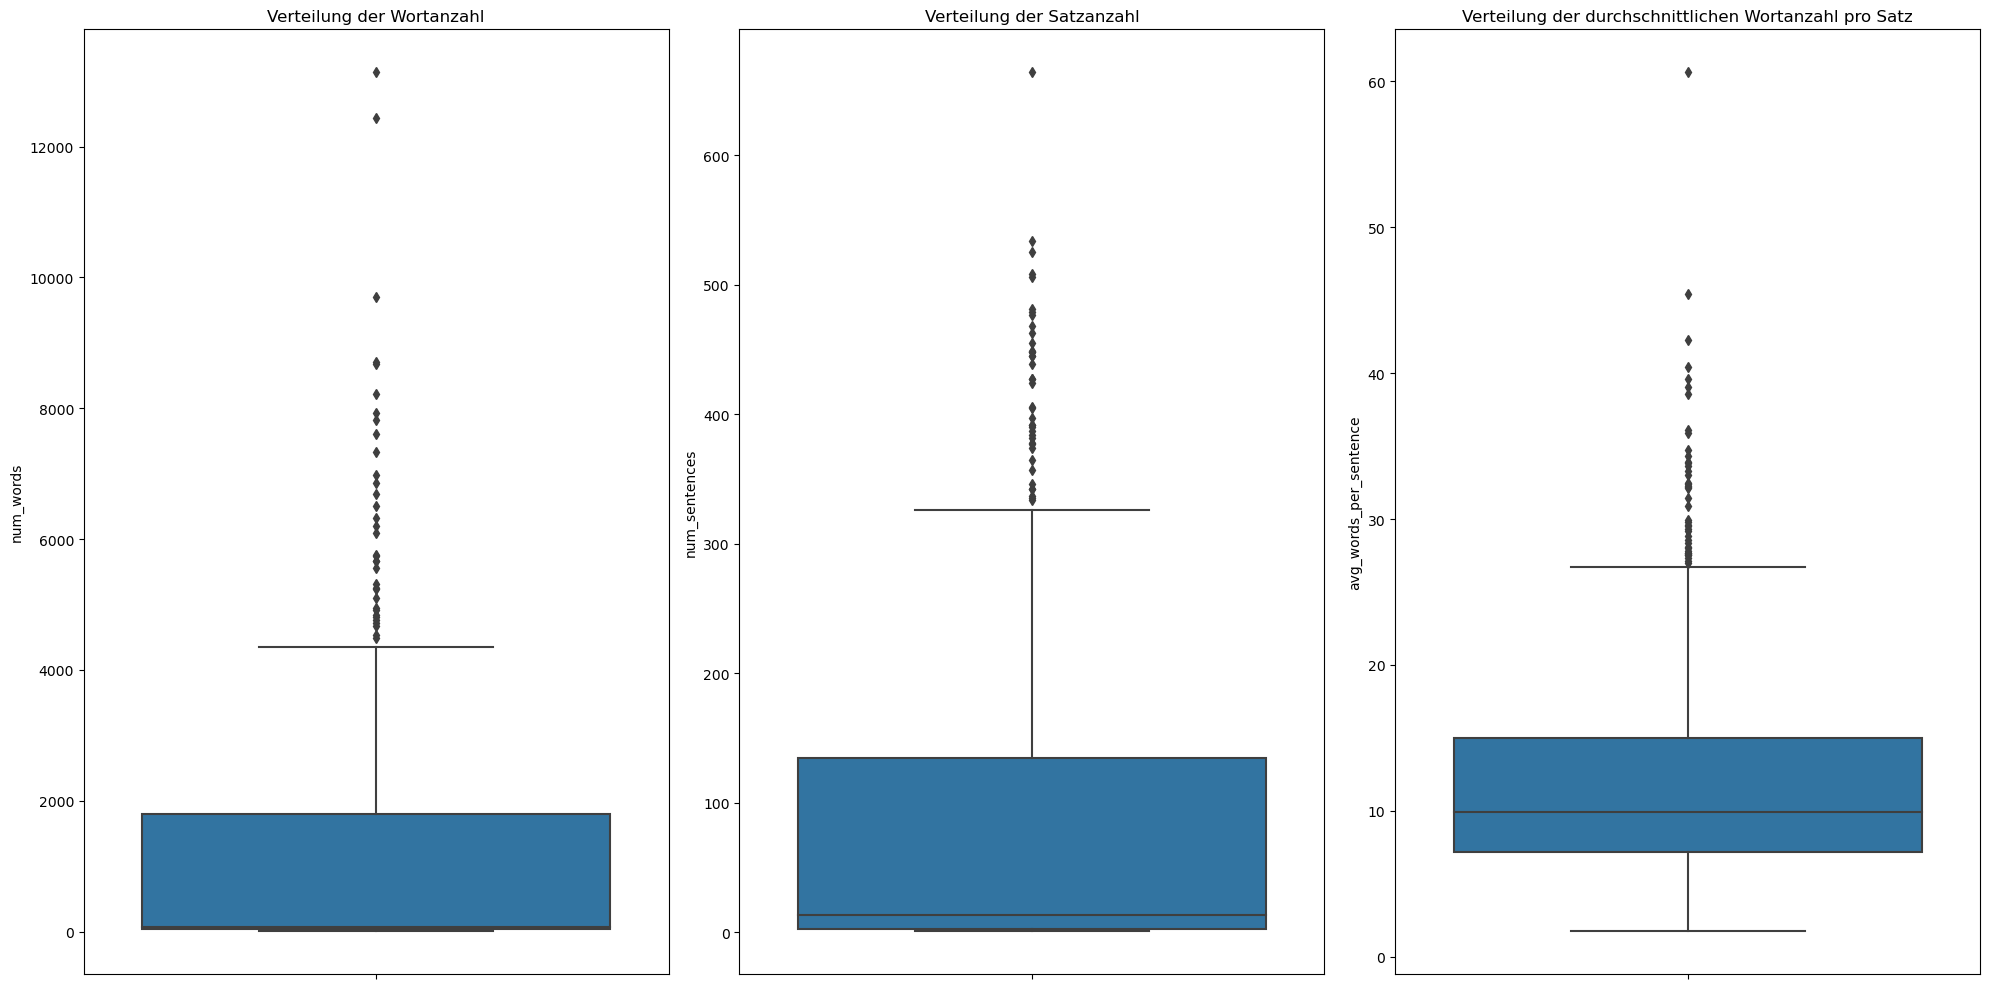

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Berechnung der durchschnittlichen Wortanzahl pro Satz
df_test['avg_words_per_sentence'] = df_test['num_words'] / df_test['num_sentences']

# Erstellung der Boxplots
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_test['num_words'])
plt.title('Verteilung der Wortanzahl')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_test['num_sentences'])
plt.title('Verteilung der Satzanzahl')

plt.subplot(1, 3, 3)
sns.boxplot(y=df_test['avg_words_per_sentence'])
plt.title('Verteilung der durchschnittlichen Wortanzahl pro Satz')

plt.tight_layout()
plt.show()


In [28]:
# Ausdrucken des Durchschnitts, der Standardabweichung, des Minimums und des Maximums für 'num_words'
print("Statistiken für 'num_words':")
print("Mean: ", df_test['num_words'].mean())
print("Std: ", df_test['num_words'].std())
print("Min: ", df_test['num_words'].min())
print("Max: ", df_test['num_words'].max())

print("\n")  # Zeilenumbruch für die Lesbarkeit

# Ausdrucken des Durchschnitts, der Standardabweichung, des Minimums und des Maximums für 'num_sentences'
print("Statistiken für 'num_sentences':")
print("Mean: ", df_test['num_sentences'].mean())
print("Std: ", df_test['num_sentences'].std())
print("Min: ", df_test['num_sentences'].min())
print("Max: ", df_test['num_sentences'].max())

print("\n")  # Zeilenumbruch für die Lesbarkeit

# Ausdrucken des Durchschnitts, der Standardabweichung, des Minimums und des Maximums für 'avg_words_per_sentence'
print("Statistiken für 'avg_words_per_sentence':")
print("Mean: ", df_test['avg_words_per_sentence'].mean())
print("Std: ", df_test['avg_words_per_sentence'].std())
print("Min: ", df_test['avg_words_per_sentence'].min())
print("Max: ", df_test['avg_words_per_sentence'].max())


Statistiken für 'num_words':
Mean:  1115.84
Std:  1647.159849213511
Min:  7
Max:  13136


Statistiken für 'num_sentences':
Mean:  84.355
Std:  113.28428017677015
Min:  1
Max:  664


Statistiken für 'avg_words_per_sentence':
Mean:  12.057614521179525
Std:  7.371799227471006
Min:  1.75
Max:  60.61875


In [29]:
import math

# Durchschnittliche Anzahl an Wörtern pro Satz berechnen
mean_words_per_sentence = df_test['avg_words_per_sentence'].mean()

# Anzahl der Sätze berechnen, die bei 1024 Wörtern genutzt werden können
num_sentences = math.floor(1024 / mean_words_per_sentence)

print("Anzahl der Sätze, die bei 1024 Wörtern genutzt werden können: ", num_sentences)


Anzahl der Sätze, die bei 1024 Wörtern genutzt werden können:  84


In [26]:
first_line = df_test['text'].iloc[0]  # Zugriff auf die erste Zeile der Spalte "text"

#print("Erste Zeile: ", first_line)
print("Länge der ersten Zeile: ", len(first_line))

Länge der ersten Zeile:  22273


In [31]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Wählen Sie das gewünschte Modell
model_name = 'facebook/bart-large-cnn'
# Laden Sie das Modell und den Tokenizer
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# Ihr Ausgangstext
original_text =first_line

In [ ]:


# Berechnen Sie die gewünschten Mindest- und Maximallängen basierend auf der Kompressionsrate
compression_rate_min = 70  # 20%
compression_rate_max = 80  # 80%
min_length = len(tokenizer(original_text)['input_ids']) * compression_rate_min // 100
max_length = len(tokenizer(original_text)['input_ids']) * compression_rate_max // 100

# Generieren Sie die Zusammenfassung
inputs = tokenizer([original_text], max_length=len(original_text), return_tensors='pt')
summary_ids = model.generate(inputs['input_ids'], num_beams=4, min_length=min_length, max_length=max_length, early_stopping=True)
summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

print(summary)

In [10]:
import pandas as pd

# Initialisiere leeren DataFrame
df_summary_testing = pd.DataFrame(columns=['Min_Kompressionsrate', 'Max_Kompressionsrate', 'Endgueltige_Kompressionsrate', 'Zusammenfassung'])

# Ausgangstextlänge
original_length = len(tokenizer(original_text)['input_ids'])

# Liste der Kompressionsraten
compression_rates = range(20, 81, 10)  # Werte von 20 bis 80 mit Schrittgröße 10

# Für jede Kompressionsrate
for rate in compression_rates:
    compression_rate_min = rate
    compression_rate_max = rate + 10 if rate + 10 <= 80 else 80  # Stellen Sie sicher, dass die max_rate 80 nicht überschreitet

    # Berechnen Sie die Mindest- und Maximallänge
    min_length = original_length * compression_rate_min // 100
    max_length = original_length * compression_rate_max // 100

    # Generieren Sie die Zusammenfassung
    inputs = tokenizer([original_text], max_length=len(original_text), return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, min_length=min_length, max_length=max_length, early_stopping=True)
    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    # Bestimmen Sie die tatsächliche Kompressionsrate der generierten Zusammenfassung
    summary_length = len(tokenizer(summary[0])['input_ids'])
    actual_compression_rate = summary_length / original_length * 100

    # Fügen Sie die Daten zum DataFrame hinzu
    df_summary_testing = df_summary_testing.append({
        'Min_Kompressionsrate': compression_rate_min,
        'Max_Kompressionsrate': compression_rate_max,
        'Endgueltige_Kompressionsrate': actual_compression_rate,
        'Zusammenfassung': summary[0]
    }, ignore_index=True)

# Zeige den DataFrame
print(df_summary_testing)


Token indices sequence length is longer than the specified maximum sequence length for this model (5669 > 1024). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


IndexError: index out of range in self

In [13]:
print(original_length * compression_rate_min // 100)
print(original_length * compression_rate_max // 100)

204
307


In [14]:
for rate in compression_rates:
    compression_rate_min = rate
    compression_rate_max = rate + 10 if rate + 10 <= 80 else 80  # Stellen Sie sicher, dass die max_rate 80 nicht überschreitet

    # Trunkieren Sie den Originaltext auf die maximale Länge, die das Modell verarbeiten kann (in diesem Fall 1024 Token)
    inputs = tokenizer([original_text], truncation=True, max_length=1024, padding='max_length', return_tensors='pt')

    # Originaltextlänge nach der Trunkierung
    original_length = len(inputs['input_ids'][0])

    # Berechnen Sie die Mindest- und Maximallänge
    min_length_test = original_length * compression_rate_min // 100
    max_length_test = original_length * compression_rate_max // 100

    # Prüfen Sie, ob die Mindest- und Maximallänge innerhalb des zulässigen Bereichs liegt
    min_length = max(1, min_length)  # min_length muss mindestens 1 sein
    max_length = min(max_length, model.config.max_length)  # max_length darf nicht länger als die maximale Länge des Modells sein

    # Generieren Sie die Zusammenfassung
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, min_length=min_length_test, max_length=max_length_test, early_stopping=True)
    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

    # Bestimmen Sie die tatsächliche Kompressionsrate der generierten Zusammenfassung
    summary_length = len(tokenizer(summary[0])['input_ids'])
    actual_compression_rate = summary_length / original_length * 100

    # Fügen Sie die Daten zum DataFrame hinzu
    df_summary_testing = df_summary_testing.append({
        'Min_Kompressionsrate': compression_rate_min,
        'Max_Kompressionsrate': compression_rate_max,
        'Endgueltige_Kompressionsrate': actual_compression_rate,
        'Zusammenfassung': summary[0]
    }, ignore_index=True)

/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/3005128698.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary_testing = df_summary_testing.append({
/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/3005128698.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary_testing = df_summary_testing.append({
/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/3005128698.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary_testing = df_summary_testing.append({
/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/3005128698.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [15]:
df_summary_testing

,Min_Kompressionsrate,Max_Kompressionsrate,Endgueltige_Kompressionsrate,Zusammenfassung
0,20,30,21.484375,String theorists @xcite exploited a moderately...
1,30,40,31.054688,String theorists @xcite exploited a moderately...
2,40,50,41.210938,String theorists @xcite exploited a moderately...
3,50,60,51.269531,String theorists @xcite exploited a moderately...
4,60,70,61.718750,String theorists @xcite exploited a moderately...
5,70,80,75.585938,String theorists @xcite exploited a moderately...
6,80,80,79.101562,String theorists @xcite exploited a moderately...


In [19]:
df_summary_testing[0:1].Zusammenfassung[0]

'String theorists @xcite exploited a moderately large size of an external 11th dimension in order to reconcile the planck and string / gut scales. Large extra dimensions allow for a reduction of the fundamental higher - dimensional gravitational scale down to the tev - scale. These models are argued to make contact with an intricate phenomenology with a variety of consequences for collider searches, low - energy precision measurements, rare decays and astroparticle physics and cosmology.however, the mechanisms , responsible for the stabilization of extra dimensions , remain unknown. An alternative solution to the hierarchy problem was proposed in ref . This higher dimensional scenario is based on a non - factorizable geometry which accounts for the ratio between the plank scale and weak scales. The distance between the branes is associated with the vacuum expectation value of a massless four dimensional scalar field. For this scenario to be relevant, it is necessary to find a mechanism

In [22]:
df_summary_testing[5:6].Zusammenfassung[5]

'String theorists @xcite exploited a moderately large size of an external 11th dimension in order to reconcile the planck and string / gut scales. Large extra dimensions allow for a reduction of the fundamental higher - dimensional gravitational scale down to the tev - scale. These models are argued to make contact with an intricate phenomenology with a variety of consequences for collider searches, low - energy precision measurements, rare decays and astroparticle physics and cosmology.however, the mechanisms , responsible for the stabilization of extra dimensions , remain unknown. An alternative solution to the hierarchy problem was proposed in ref . This higher dimensional scenario is based on a non - factorizable geometry which accounts for the ratio between the plank scale and weak scales. The distance between the branes is associated with the vacuum expectation value of a massless four dimensional scalar field. For this scenario to be relevant, it is necessary to find a mechanism

müssen den code verbessern oder ne gpu dran machen

In [33]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained('bert-base-cased')

df_summary_testing = pd.DataFrame(columns=['Min_Kompressionsrate', 'Max_Kompressionsrate', 'Endgueltige_Kompressionsrate', 'Zusammenfassung'])
tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token else '[PAD]'

# Teilen Sie den Text in Sätze
sentences = original_text.split('. ')

# Erstellen Sie Batches von Sätzen, die weniger als 1024 Tokens enthalten
batches = []
batch = []
batch_len = 0
for sentence in sentences:
    sentence_len = len(tokenizer.tokenize(sentence))
    if sentence_len + batch_len > 1024:
        if sentence_len < 1024:  # überspringen Sie Sätze, die länger als 1024 Tokens sind
            batches.append(batch)
            batch = [sentence]
            batch_len = sentence_len
        # wenn ein Satz alleine 1024 Tokens überschreitet, wird er übersprungen
    else:
        batch.append(sentence)
        batch_len += sentence_len
batches.append(batch)  # fügen Sie den letzten Batch hinzu

# Führen Sie die Zusammenfassung für jeden Batch durch
for rate in compression_rates:
    compression_rate_min = rate
    compression_rate_max = rate + 10 if rate + 10 <= 80 else 80  # Stellen Sie sicher, dass die max_rate 80 nicht überschreitet

    for batch in batches:
        # Zusammenfügen der Sätze in einem Batch
        batch_text = '. '.join(batch)
        
        inputs = tokenizer([batch_text], truncation=True, max_length=1024, padding='max_length', return_tensors='pt')

        # Originaltextlänge nach der Trunkierung
        original_length = len(inputs['input_ids'][0])

        # Berechnen Sie die Mindest- und Maximallänge
        min_length_test = original_length * compression_rate_min // 100
        max_length_test = original_length * compression_rate_max // 100

        # Generieren Sie die Zusammenfassung
        summary_ids = model.generate(inputs['input_ids'], num_beams=4, min_length=min_length_test, max_length=max_length_test, early_stopping=True)
        summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

        # Bestimmen Sie die tatsächliche Kompressionsrate der generierten Zusammenfassung
        summary_length = len(tokenizer(summary[0])['input_ids'])
        actual_compression_rate = summary_length / original_length * 100

        # Fügen Sie die Daten zum DataFrame hinzu
        df_summary_testing = df_summary_testing.append({
            'Min_Kompressionsrate': compression_rate_min,
            'Max_Kompressionsrate': compression_rate_max,
            'Endgueltige_Kompressionsrate': actual_compression_rate,
            'Zusammenfassung': summary[0]
        }, ignore_index=True)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Using eos_token, but it is not set yet.
/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/1734927330.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary_testing = df_summary_testing.append({
/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/1734927330.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary_testing = df_summary_testing.append({
/var/folders/k3/z_svrdgd6sb9lc9bqdfzp_k00000gn/T/ipykernel_3271/1734927330.py:54: FutureWarning: The frame.append method is depreca

In [ ]:
from transformers import PreTrainedTokenizerFast
from tqdm import tqdm

tokenizer = PreTrainedTokenizerFast.from_pretrained('bert-base-cased')
tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token else '[PAD]'

df_summary_testing = pd.DataFrame(columns=['Min_Kompressionsrate', 'Max_Kompressionsrate', 'Endgueltige_Kompressionsrate', 'Zusammenfassung'])

# Teilen Sie den Text in Sätze
sentences = original_text.split('. ')

# Erstellen Sie Batches von Sätzen, die weniger als 1024 Tokens enthalten
batches = []
batch = []
batch_len = 0
for sentence in sentences:
    sentence_len = len(tokenizer.tokenize(sentence))
    if sentence_len + batch_len > 1024:
        if sentence_len < 1024:  # überspringen Sie Sätze, die länger als 1024 Tokens sind
            batches.append(batch)
            batch = [sentence]
            batch_len = sentence_len
        # wenn ein Satz alleine 1024 Tokens überschreitet, wird er übersprungen
    else:
        batch.append(sentence)
        batch_len += sentence_len
batches.append(batch)  # fügen Sie den letzten Batch hinzu

# Führen Sie die Zusammenfassung für jeden Batch durch
for rate in tqdm(compression_rates, desc='Verarbeite Kompressionsraten'):
    compression_rate_min = rate
    compression_rate_max = rate + 10 if rate + 10 <= 80 else 80  # Stellen Sie sicher, dass die max_rate 80 nicht überschreitet

    for batch in tqdm(batches, desc='Verarbeite Batches'):
        # Zusammenfügen der Sätze in einem Batch
        batch_text = '. '.join(batch)
        
        inputs = tokenizer([batch_text], truncation=True, max_length=1024, padding='max_length', return_tensors='pt')

        # Originaltextlänge nach der Trunkierung
        original_length = len(inputs['input_ids'][0])

        # Berechnen Sie die Mindest- und Maximallänge
        min_length_test = original_length * compression_rate_min // 100
        max_length_test = original_length * compression_rate_max // 100

        # Generieren Sie die Zusammenfassung
        summary_ids = model.generate(inputs['input_ids'], num_beams=4, min_length=min_length_test, max_length=max_length_test, early_stopping=True)
        summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

        # Bestimmen Sie die tatsächliche Kompressionsrate der generierten Zusammenfassung
        summary_length = len(tokenizer(summary[0])['input_ids'])
        actual_compression_rate = summary_length / original_length * 100

        # Erstellen Sie einen DataFrame für die aktuellen Ergebnisse
        df_current = pd.DataFrame({
            'Min_Kompressionsrate': [compression_rate_min],
            'Max_Kompressionsrate': [compression_rate_max],
            'Endgueltige_Kompressionsrate': [actual_compression_rate],
            'Zusammenfassung': [summary[0]]
        })

        # Fügen Sie die Daten zum DataFrame hinzu
        df_summary_testing = pd.concat([df_summary_testing, df_current], ignore_index=True)


In [34]:
df_summary_testing

,Min_Kompressionsrate,Max_Kompressionsrate,Endgueltige_Kompressionsrate,Zusammenfassung
0,20,30,56.152344,[unused2] А rebuilding [unused8] կ the [unused...
1,20,30,48.046875,[unused2] from x @ x @h @ xh [unused4] 1949 xh...
2,20,30,58.691406,[unused2] < x [unused76] [unused40] [unused28]...
3,20,30,58.398438,[unused2] < ī \ [unused31] [unused5] _ [unused...
4,20,30,21.972656,[unused2] a ) : @ xmath72. these points are ze...
5,20,30,31.054688,[unused2] А the boundary conditions for the co...
6,20,30,50.195312,"[unused2] ( et [unused4] ; ( * p, [unused55] [..."
7,30,40,86.035156,[unused2] А rebuilding [unused8] կ the [unused...
8,30,40,80.664062,[unused2] from x @ x @h @ xh [unused4] 1949 xh...
9,30,40,86.425781,[unused2] < x [unused76] [unused40] [unused28]...


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Laden Sie das DistilBERT-Modell und Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
import torch
from tqdm import tqdm
import platform

# Überprüfen, ob eine GPU verfügbar ist und das Gerät entsprechend einstellen
device = torch.device("cuda" if torch.cuda.is_available() and platform.system() == "Windows" else "cpu")

# Wenn das System ein Mac ist, aktivieren Sie die MPS (Metal Performance Shaders)
if platform.system() == "Darwin":
    torch.backends.mps.set_enabled(True)

# Verschieben Sie das Modell auf das Gerät
model = model.to(device)

compression_rates = list(range(20, 81, 10))
df_summary_testing = pd.DataFrame(columns=['Min_Kompressionsrate', 'Max_Kompressionsrate', 'Endgueltige_Kompressionsrate', 'Zusammenfassung'])

for rate in tqdm(compression_rates):
    compression_rate_min = rate
    compression_rate_max = rate + 10 if rate + 10 <= 80 else 80

    split_text = original_text.split('. ')
    chunks = [". ".join(split_text[i:i+chunks_per_summary]) for i in range(0, len(split_text), chunks_per_summary)]

    summaries = []
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors='pt').to(device)
        min_length = len(inputs['input_ids'][0]) * compression_rate_min // 100
        max_length = len(inputs['input_ids'][0]) * compression_rate_max // 100

        # Beam-Suche mit weniger Strahlen für eine schnellere Ausführung
        summary_ids = model.generate(inputs['input_ids'], num_beams=2, min_length=min_length, max_length=max_length, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
        summaries.append(summary)

    combined_summary = ' '.join(summaries)
    summary_length = len(tokenizer(combined_summary)['input_ids'])
    actual_compression_rate = summary_length / len(tokenizer(original_text)['input_ids']) * 100

    df_summary_testing = df_summary_testing.append({
        'Min_Kompressionsrate': compression_rate_min,
        'Max_Kompressionsrate': compression_rate_max,
        'Endgueltige_Kompressionsrate': actual_compression_rate,
        'Zusammenfassung': combined_summary
    }, ignore_index=True)